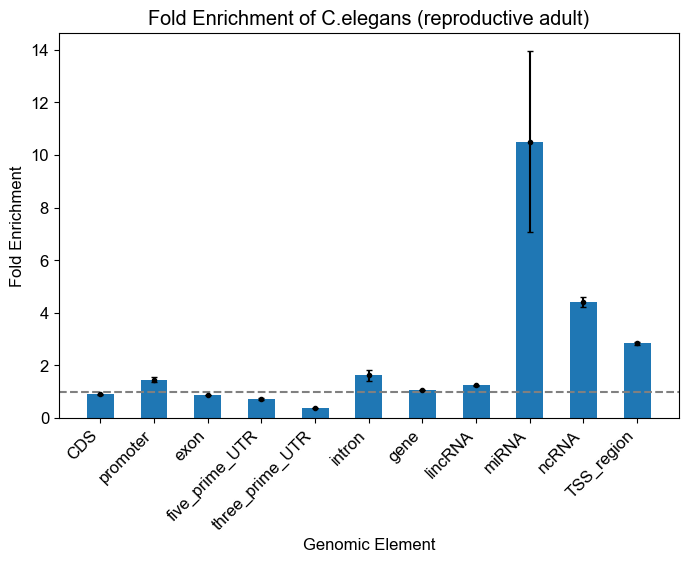

In [2]:
# imports
import gffpandas.gffpandas as gffpd
from pybedtools import BedTool 
import pybedtools
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def peaks2bed(peak_file):
    '''convert peaks file to bedtool object'''
    return BedTool(peak_file).sort()

def intersect_func(genomic_element, peaks):
    '''intersect genomic element file with observed peaks'''
    intersection = BedTool(genomic_element).sort().intersect(peaks)
    intersection_df = pd.read_table(intersection.fn, names=['seq_id', 'start', 'end'])
    num_overlaps = intersection_df.shape[0]

    return num_overlaps

def construct_genomic_df(peaks):
    '''construct df with elements and observed overlaps'''
    genomic_elements = ['c-elegans-11-CDS.bed', 'c-elegans-11-promoter.bed', 
                        'c-elegans-11-exon.bed', 'c-elegans-11-five_prime_UTR.bed', 
                    'c-elegans-11-three_prime_UTR.bed', 'c-elegans-11-intron.bed', 
                    'c-elegans-11-gene.bed', 'c-elegans-11-lincRNA.bed', 'c-elegans-11-miRNA.bed', 
                    'c-elegans-11-ncRNA.bed', 'c-elegans-11-TSS_region.bed']
    genomic_elements = [f'ce-11-beds/{name}' for name in genomic_elements]

    genomic_df = pd.DataFrame(genomic_elements, columns=['genomic element'])
    genomic_df['overlaps'] = genomic_df['genomic element'].map(lambda x: intersect_func(x, peaks))
    return genomic_df

def shuffled_intersects(element, peaks, genome_file):
    '''return intersect of an element with shuffled peaks'''
    shuffled = peaks.shuffle(g=genome_file)
    return intersect_func(element, shuffled)

def run_shuffle_intersects(df, num, peaks, genome_file):
    '''run intersects for all elements'''
    for i in range(num):
        df[f'shuffle_overlap{i+1}'] = df['genomic element'].map(lambda x: shuffled_intersects(x, peaks, genome_file))

def calc_stats(df, num):
    '''calculates mean and standard error for fold enrichment'''
    cols = list()
    for i in range(num):
        df[f'fe{i+1}'] = df['overlaps']/df[f'shuffle_overlap{i+1}']
        cols.append(f'fe{i+1}')
    df['fe_mean'] = df[cols].mean(axis=1)
    df['se'] = df[cols].sem(axis=1)

def make_fig(df):
    df['genomic element'] = df['genomic element'].str[24:-4]
    
    x = df['genomic element']
    y = df['fe_mean']
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x, y, width=0.5)
    ax.set(title='Fold Enrichment of C.elegans (reproductive adult)', xlabel='Genomic Element', ylabel='Fold Enrichment')
    plt.xticks(rotation=45, ha='right')
    plt.axhline(y = 1, color = 'gray', linestyle = 'dashed') 
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = ["Arial"]
    plt.rcParams.update({'font.size': 12})
    ax.errorbar(x, y, yerr=df['se'], fmt='.', color="black", capsize=2)
    plt.savefig('ce11-figs/ce11-fe-figs/celegans_fe_repAd(5).svg', bbox_inches='tight')

def main():
    p = peaks2bed('BG4_repAd_HQ.bed')
    df = construct_genomic_df(p)

    num_shuffles = 5
    gf = 'ce11.genome'
    run_shuffle_intersects(df, num_shuffles, p, gf)
    calc_stats(df, 5)
    # save to csv file
    df.to_csv('ce11-intersects/ce11-repAd-intersects.csv')

    make_fig(df)


main()

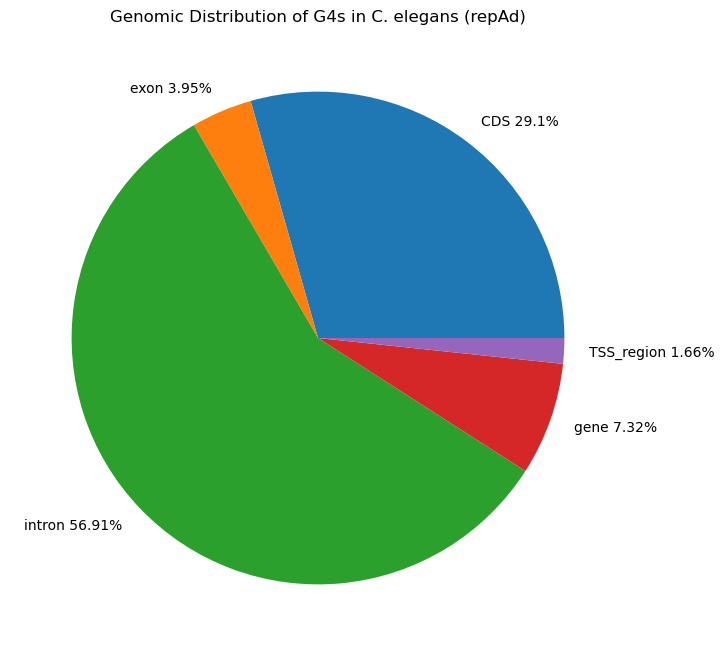

In [34]:
'''
def make_pie(df):
    df['genomic element'] = df['genomic element'].str[24:-4]
    sizes = df['overlaps']/df['overlaps'].sum()
    labels = [x + ' ' + str(round(y*100, 2)) + '%' for x, y in zip(list(df['genomic element']), sizes)]
    

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(sizes, labels=labels, autopct='%1.1f%%')
    '''

def make_pie(df, threshold=1):
    df['genomic element'] = df['genomic element'].str[24:-4]
    sizes = df['overlaps'] / df['overlaps'].sum()
    
    percentages = sizes * 100
    
    # remove below the threshold
    filtered_labels = [x + ' ' + str(round(y, 2)) + '%' for x, y in zip(list(df['genomic element']), percentages) if y >= threshold]
    filtered_sizes = [size for size, percent in zip(sizes, percentages) if percent >= threshold]
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(filtered_sizes, labels=filtered_labels)
    ax.set(title='Genomic Distribution of G4s in C. elegans (repAd)')
    plt.savefig('ce11-fold-enrichment-figs/ce11-pie-chart-figs/celegans_pie_repAd.svg', bbox_inches='tight')

def main():
    p = peaks2bed('BG4_repAd_HQ.bed')
    df = construct_genomic_df(p)
    make_pie(df, 1)

main()


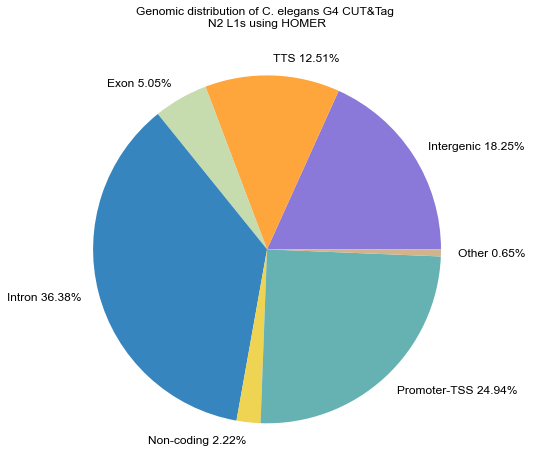

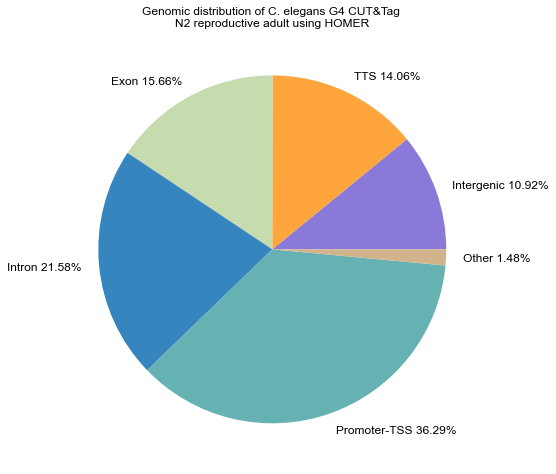

In [193]:
import matplotlib.font_manager as fm

def make_pie(df, type, out_path):
    sizes = (df.groupby('Annotation').size()/len(df['Annotation']))*100
    sum_other = sum(sizes[sizes < 1])
    sizes = sizes[sizes >= 1]
    sizes['Other'] = sum_other
    
    labels = sizes.index

    color_map = {
        'Intergenic':'#8B79D9',
        'TTS':'#fea53b',
        'exon':'#c6dbae',
        'intron':'#3685be',
        'promoter-TSS':'#66b2b2',
        'non-coding':'#efd453',
        'Other':'#D2B48C'
    }
    colors = [color_map[name] for name in labels]
    labels = [x[0].upper() + x[1:] + ' ' + str(round(y, 2)) + '%' for x, y in zip(list(labels), sizes)]

    font_path = "../../usr/share/fonts/truetype/dejavu/arial.ttf"
    prop = fm.FontProperties(fname=font_path)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(sizes, labels=labels, colors=colors, textprops={'fontproperties': prop, 'fontsize':12})
    ax.set_title(label=f'Genomic distribution of C. elegans G4 CUT&Tag \nN2 {type} using HOMER', fontproperties=prop, fontsize=12)
    plt.savefig(out_path, bbox_inches='tight')

def main():
    file_dict = {'L1s':['L1-annotation-analysis.csv', 'ce11-figs/ce11-pie-chart-figs/celegans_pie_L1.svg'],
                 'reproductive adult':['repAd-annotation-analysis.csv', 'ce11-figs/ce11-pie-chart-figs/celegans_pie_repAd.svg']}
    for type, files in file_dict.items():
        annotations = pd.read_csv(files[0])
        annotations['Annotation'] = annotations['Annotation'].str.split(' ').str[0]
        annotations.dropna(subset=['Annotation'], inplace=True)
        make_pie(annotations, type, files[1])

main()